In [17]:
%load_ext nb_black
import pandas as pd
import matplotlib.pyplot as plt
from combine import recombine
import tabulate

potholes = recombine("data/potholes_1.csv", "data/potholes_2.csv")

potholes = potholes.iloc[:,
    [0, 1, 2, 3, 5, 6, 9, 10, 11, 12, 13, 14, 16, 17, 18
    ]
]
potholes = potholes.drop_duplicates(subset = "SERVICE REQUEST NUMBER")
potholes = potholes.dropna(subset = ["ZIP", "Community Area"])
potholes['Community Area'] = potholes['Community Area'].astype(int).astype('category')

# Rename variables
potholes.rename(columns = {"CREATION DATE": "Creation Date",
                          "STATUS" :"Status",
                          "COMPLETION DATE": "Completion Date",
                          "CURRENT ACTIVITY": "Current Activity",
                          "MOST RECENT ACTION": "Most Recent Action"}, inplace = True)

<IPython.core.display.Javascript object>

In [2]:
# Convert strings to times
potholes["Creation Date"] = pd.to_datetime(potholes["Creation Date"], format = "%m/%d/%Y")
potholes["Completion Date"] = pd.to_datetime(potholes["Completion Date"], format = "%m/%d/%Y")

# Create completion time variable
potholes["Completion Time"] = potholes["Completion Date"] - potholes["Creation Date"]
potholes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 556672 entries, 1 to 560477
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype          
---  ------                  --------------   -----          
 0   Creation Date           556672 non-null  datetime64[ns] 
 1   Status                  556672 non-null  object         
 2   Completion Date         549404 non-null  datetime64[ns] 
 3   SERVICE REQUEST NUMBER  556672 non-null  object         
 4   Current Activity        391045 non-null  object         
 5   Most Recent Action      389443 non-null  object         
 6   ZIP                     556672 non-null  float64        
 7   X COORDINATE            556538 non-null  float64        
 8   Y COORDINATE            556538 non-null  float64        
 9   Ward                    556671 non-null  float64        
 10  Police District         556671 non-null  float64        
 11  Community Area          556672 non-null  category       
 12  LATITUDE        

In [3]:
census_data = pd.read_csv('data/chicago_census_data.csv')
census_data = census_data.iloc[:, [0,1,7,8]].dropna()
census_data['HARDSHIP INDEX'] = census_data['HARDSHIP INDEX'].astype(int)
census_data = census_data.rename(columns = {'Community Area Number': 'Community Area', "COMMUNITY AREA NAME": "Community Area Name", "HARDSHIP INDEX": "Hardship Index", "PER CAPITA INCOME ": "Per Capita Income"})
census_data = census_data.dropna(subset=["Community Area", "Hardship Index", "Per Capita Income"])
print(census_data)

    Community Area Community Area Name  Per Capita Income  Hardship Index
0              1.0         Rogers Park              23939              39
1              2.0          West Ridge              23040              46
2              3.0              Uptown              35787              20
3              4.0      Lincoln Square              37524              17
4              5.0        North Center              57123               6
..             ...                 ...                ...             ...
72            73.0   Washington Height              19713              48
73            74.0     Mount Greenwood              34381              16
74            75.0         Morgan Park              27149              30
75            76.0              O'Hare              25828              24
76            77.0           Edgewater              33385              19

[77 rows x 4 columns]


In [4]:
potholes_c = potholes.groupby(["Community Area"])['Creation Date'].count()
potholes_mean = potholes.groupby(["Community Area"]).agg({'Completion Time': 'mean'})
pd_holes = potholes_c.to_frame(name='Count').reset_index()
potholes_mean["Completion Time"] = potholes_mean["Completion Time"].apply(lambda x: x.days)

In [37]:
census_data['Community Area'] = census_data['Community Area'].astype(int)
merged_data = pd.merge(census_data, pd_holes, on = 'Community Area')
working_data = pd.merge(merged_data, potholes_mean, on = 'Community Area').sort_values(["Completion Time"], ascending = False)
working_data['Community Area'] = working_data['Community Area'].astype('category')

<IPython.core.display.Javascript object>

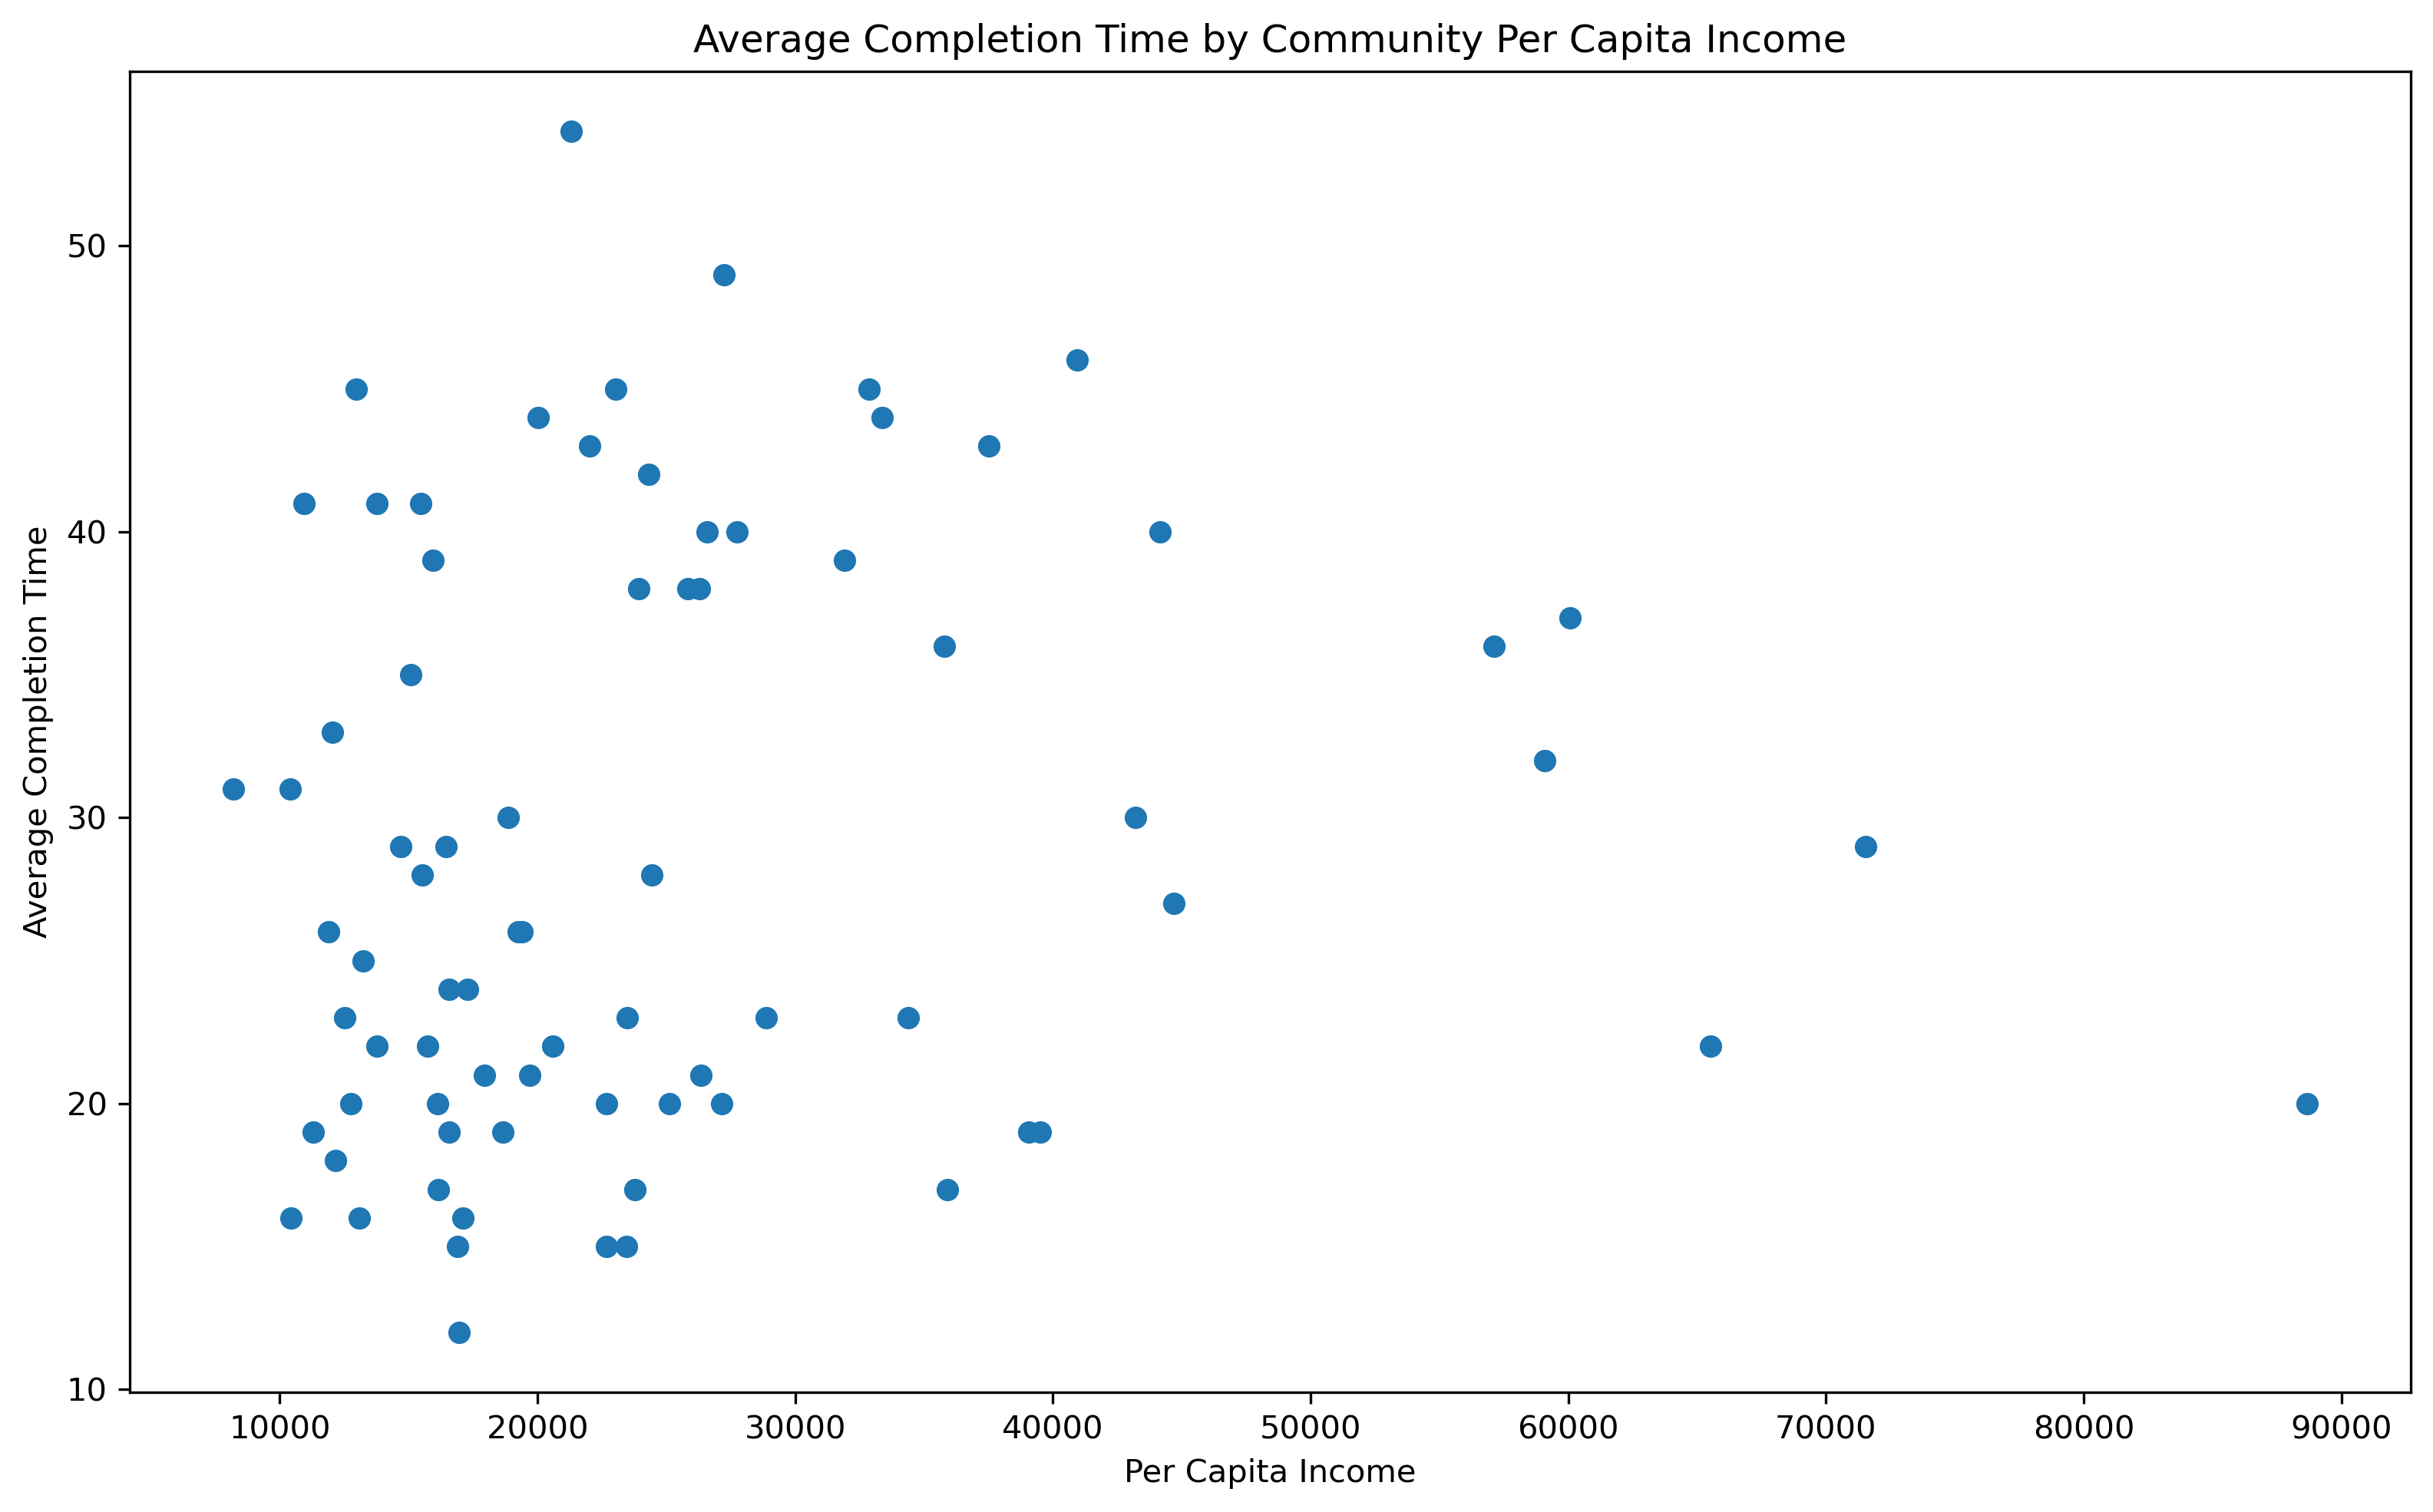

<IPython.core.display.Javascript object>

In [38]:
fig = plt.figure(figsize=(16 / 1.5, 10 / 1.5), dpi=300)
plt.scatter(working_data["Per Capita Income"], working_data["Completion Time"])
plt.title("Average Completion Time by Community Per Capita Income")
plt.xlabel("Per Capita Income")
plt.ylabel("Average Completion Time")
plt.show()

# Save to artifacts
scatter_fig = fig.get_figure()
scatter_fig.savefig("artifacts/income_scatter.png")

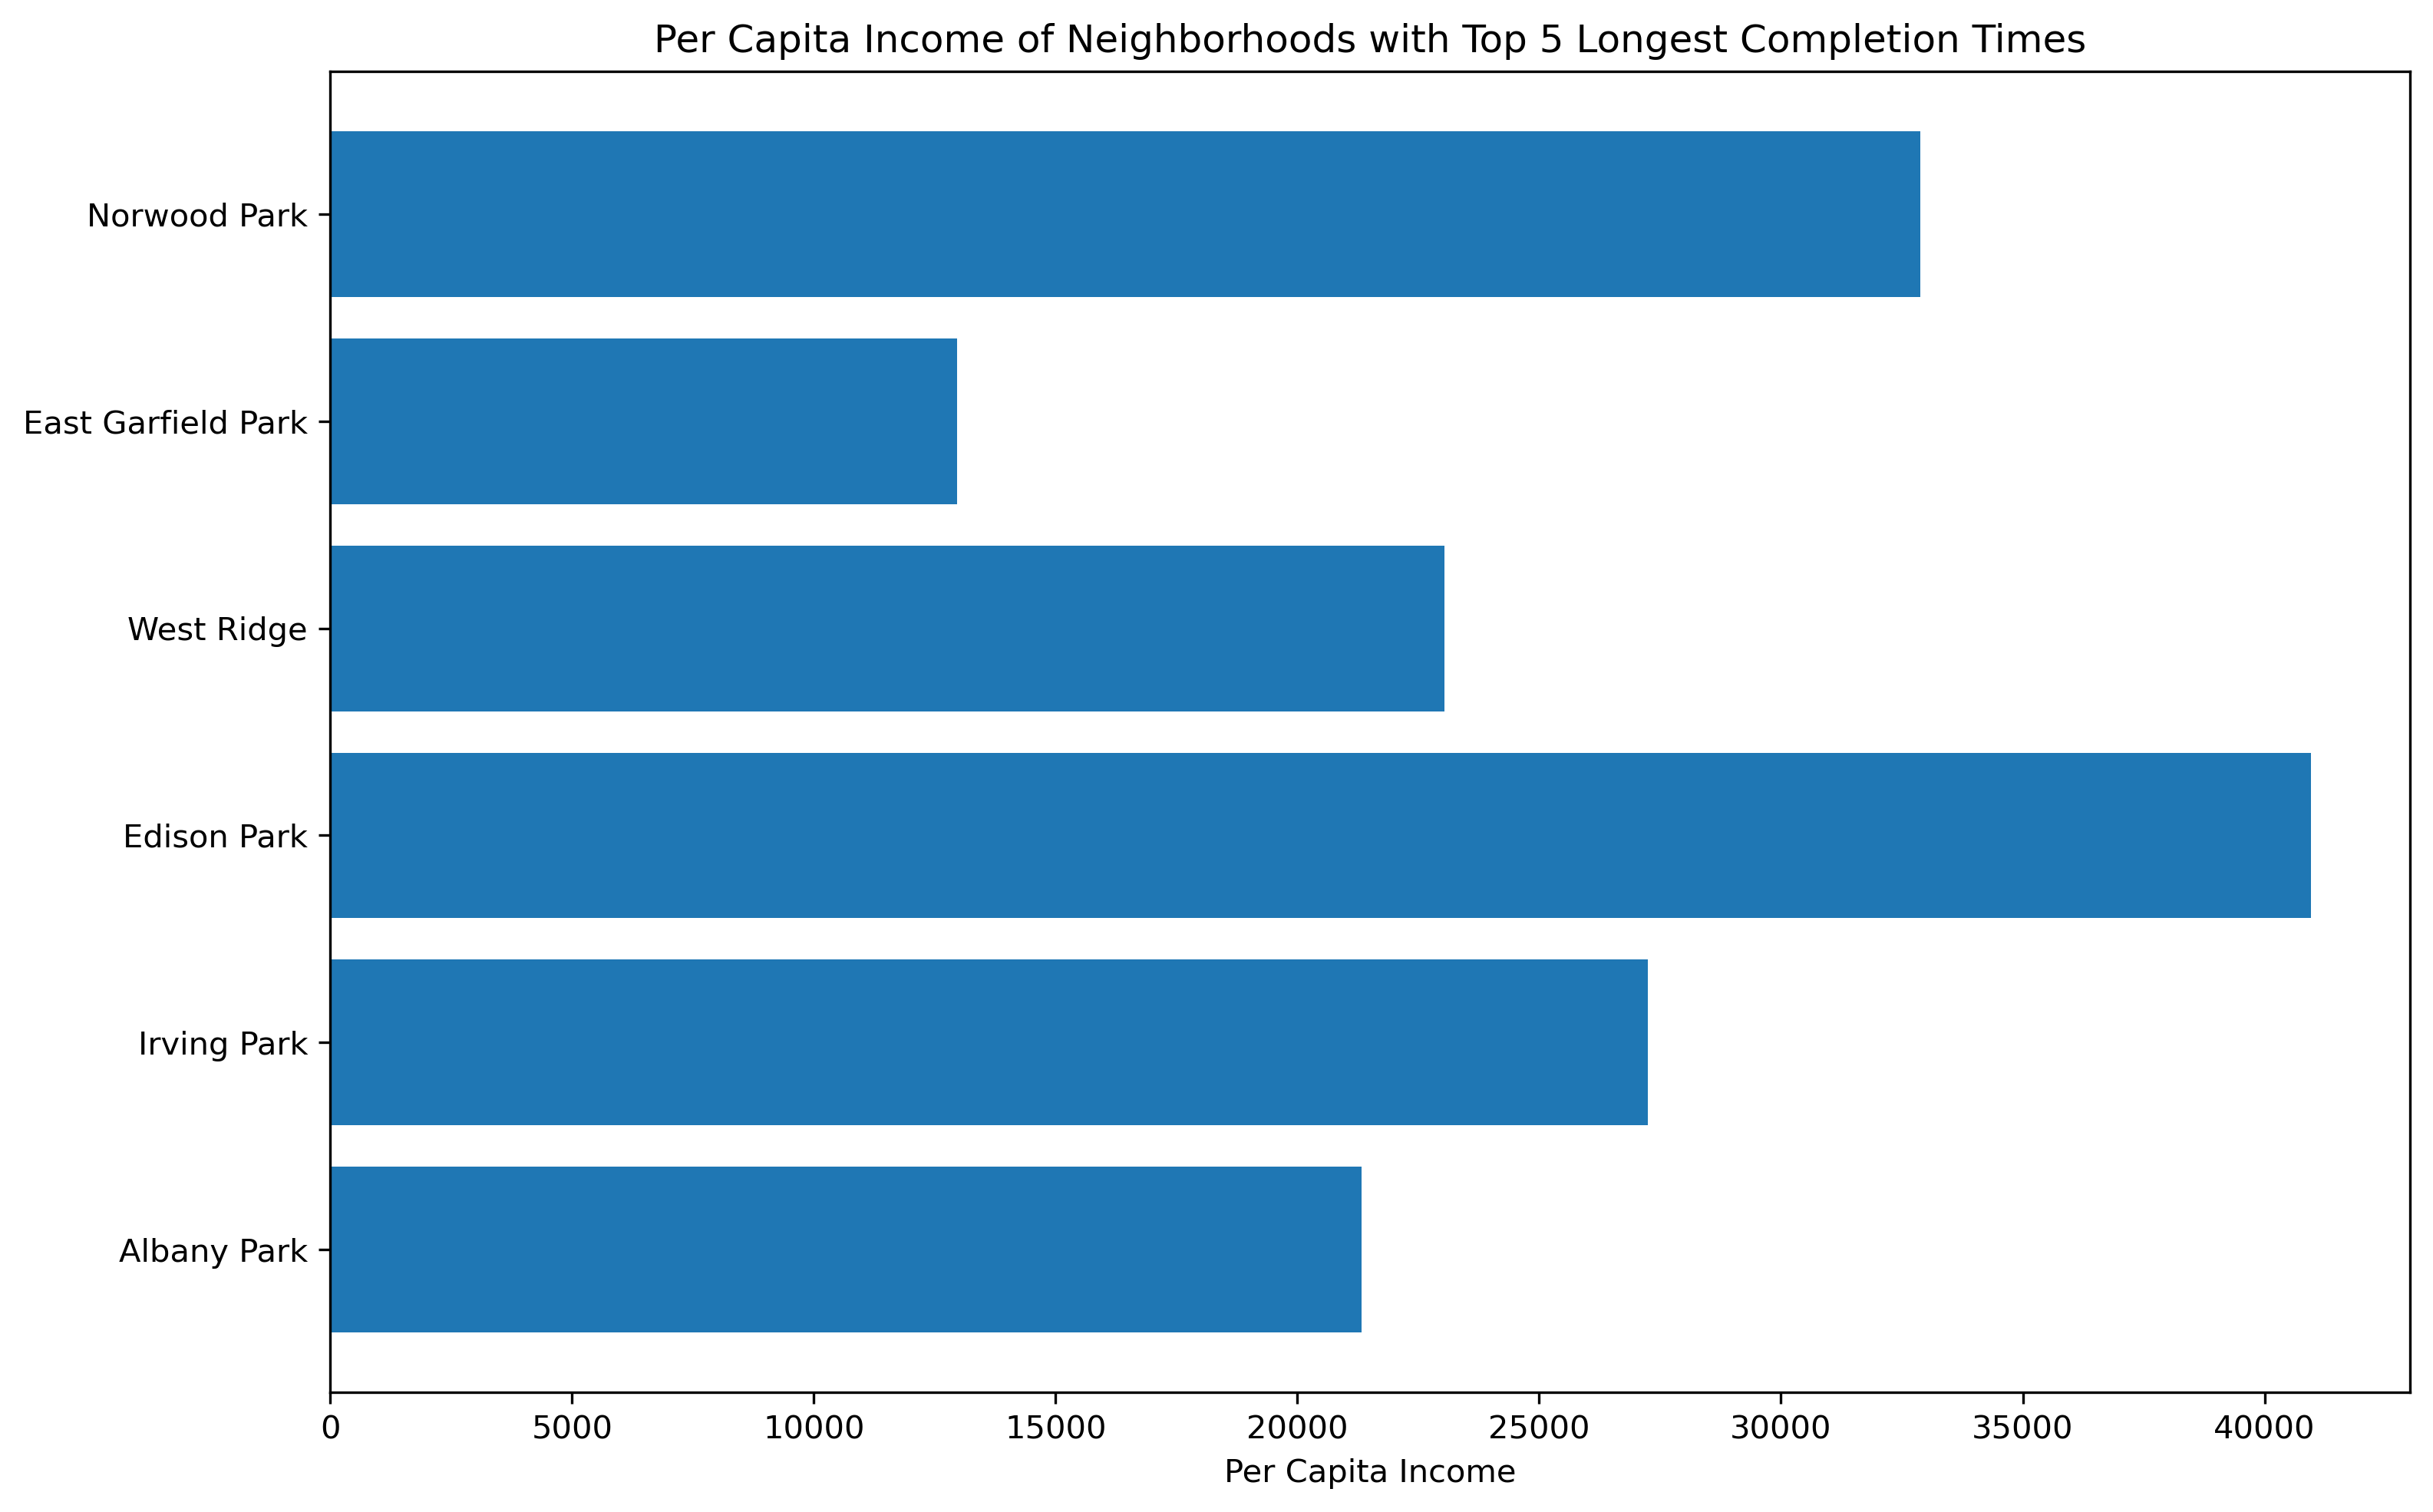

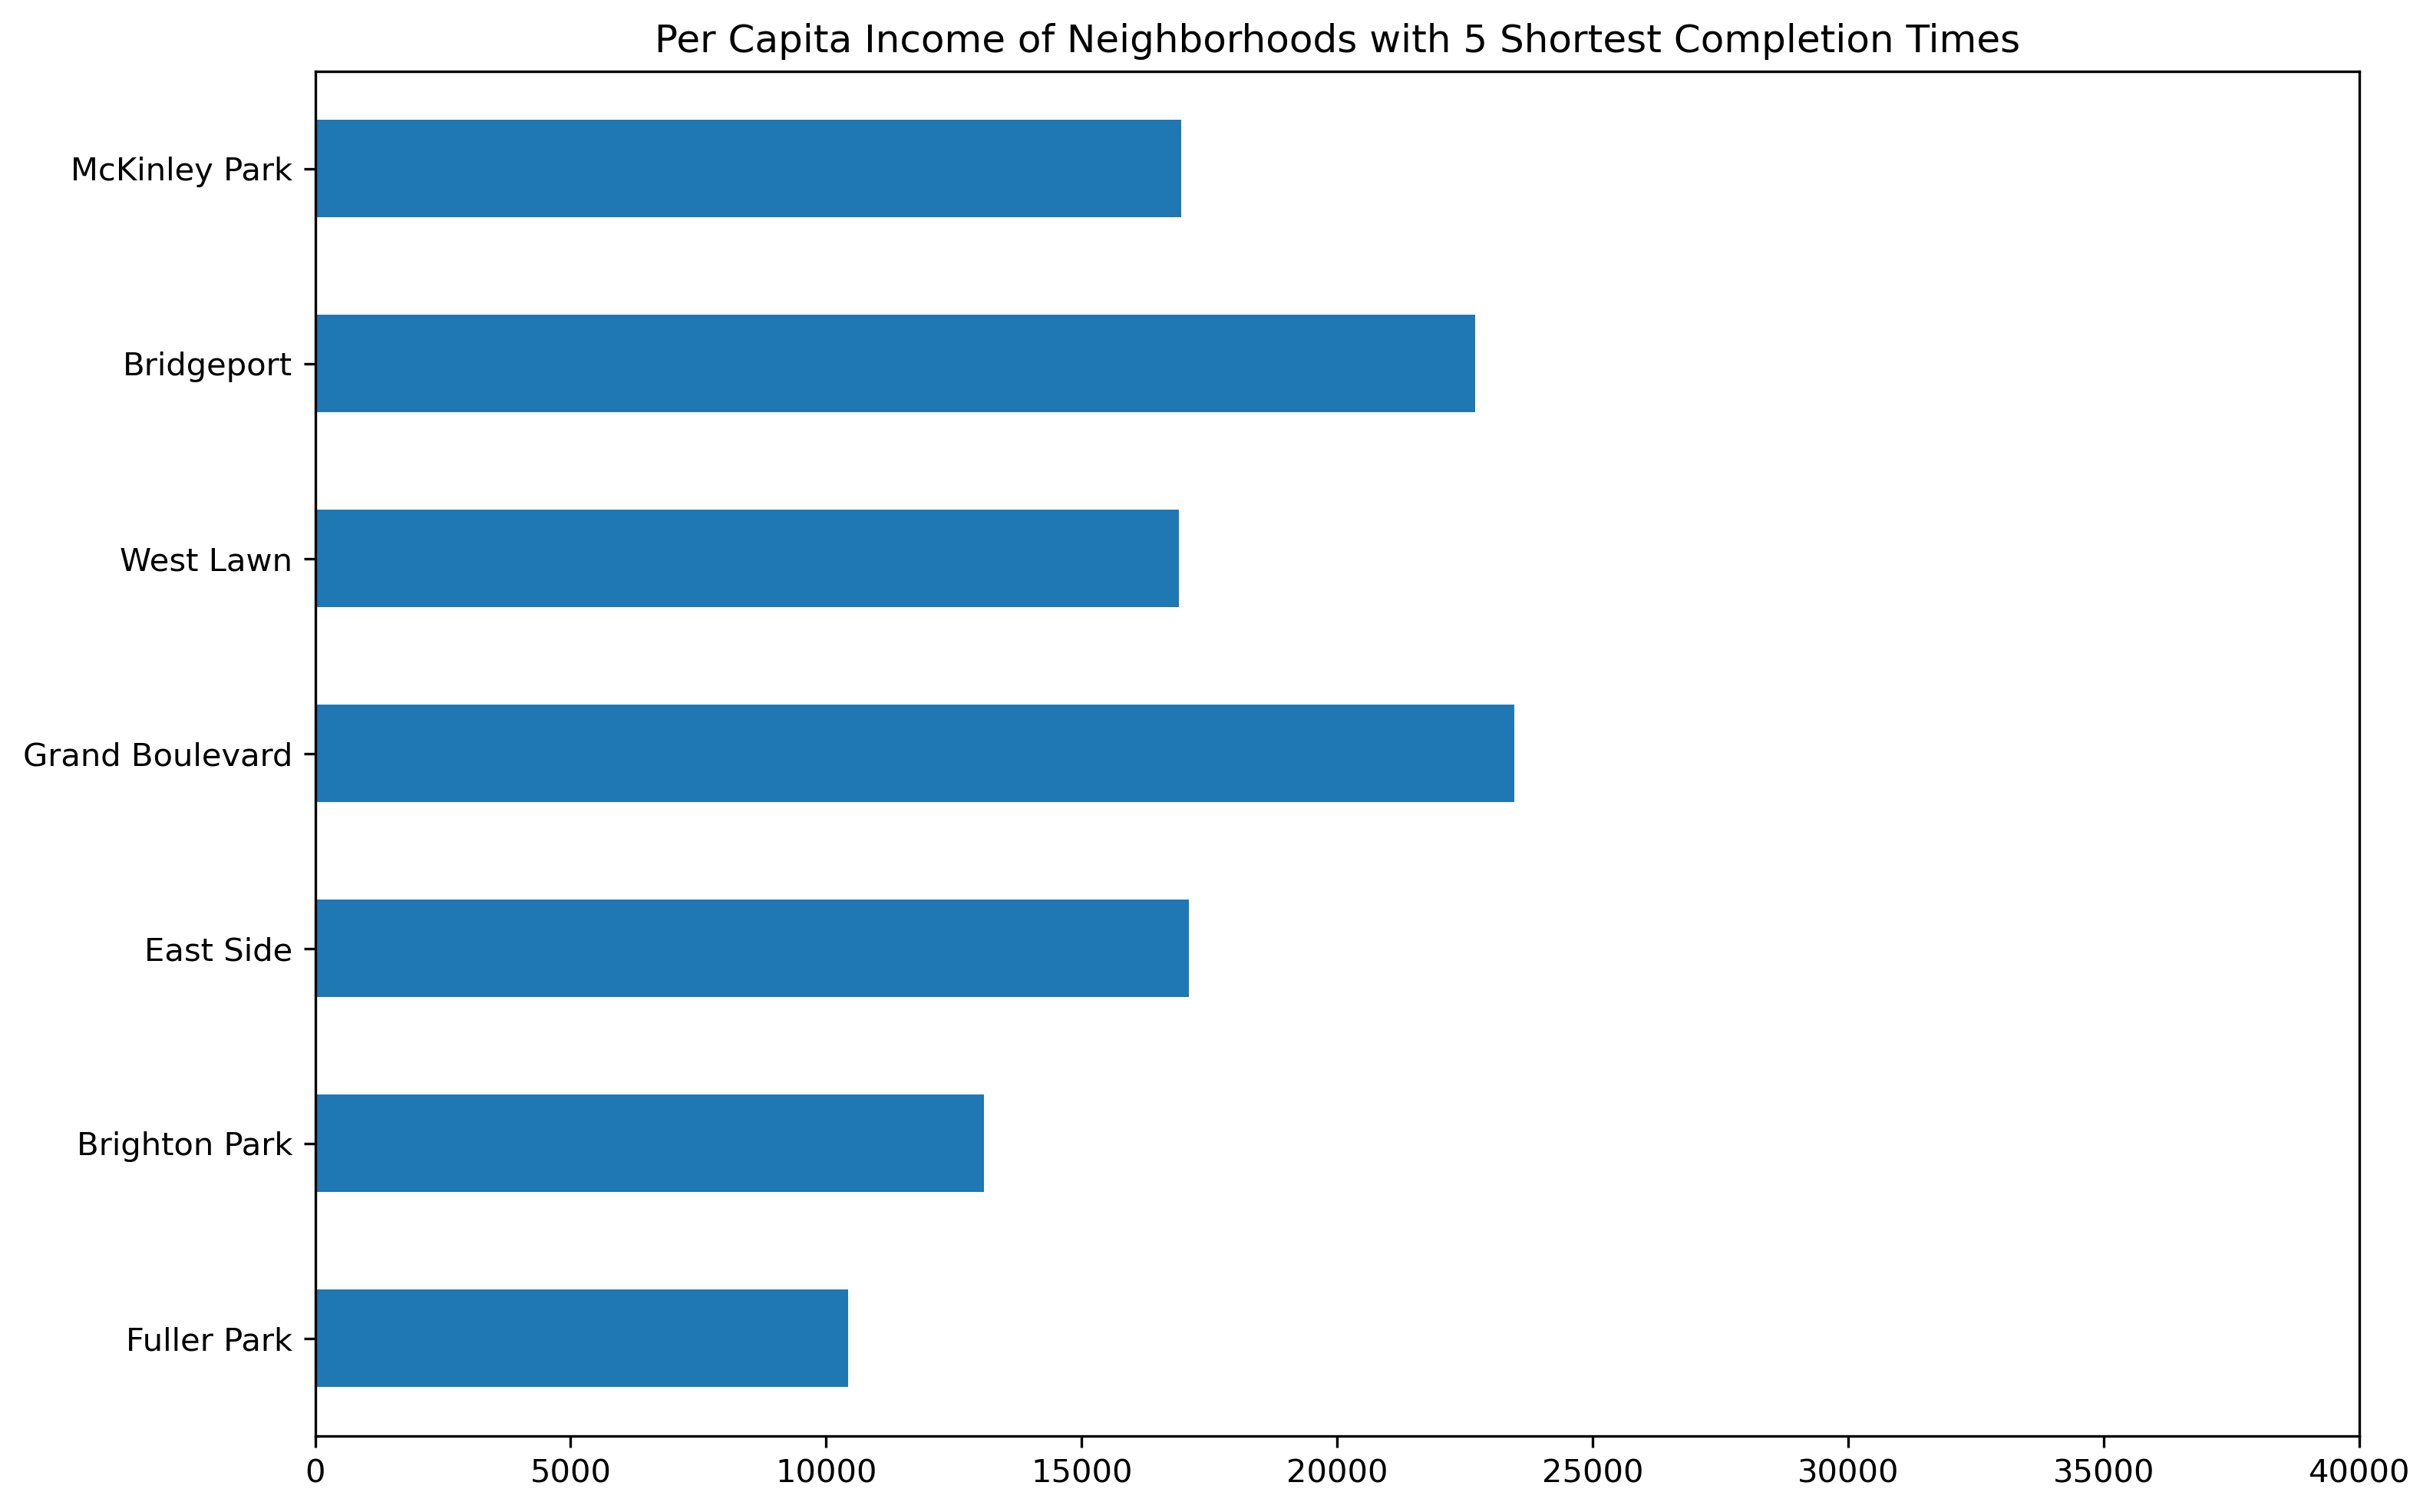

<IPython.core.display.Javascript object>

In [36]:
# What is the per capita income of commmunities with top 5 longest completion times?
# Bottom 5?
fig_1 = plt.figure(figsize=(16 / 1.5, 10 / 1.5), dpi=300)
top_5 = working_data[working_data["Completion Time"] >= 45]
bottom_5 = working_data[working_data["Completion Time"] <= 16]
bottom_5

plt.barh(top_5["Community Area Name"], top_5["Per Capita Income"])
plt.title("Per Capita Income of Neighborhoods with Top 5 Longest Completion Times")
plt.xlabel("Per Capita Income")
plt.show()


# Use pandas for this plot
plt.rcParams["figure.figsize"] = [16 / 1.5, 10 / 1.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 300
fig_2 = bottom_5.plot("Community Area Name", "Per Capita Income", kind = "barh", 
              title = "Per Capita Income of Neighborhoods with 5 Shortest Completion Times",
              xlim = [0, 40000],
             ylabel = "Per Capita Income",
             xlabel = "",
             legend = False)

# Save plots to artifacts
top_5 = fig_1.get_figure()
top_5.savefig("artifacts/top_5.png")
bottom_5 = fig_2.get_figure()
bottom_5.savefig("artifacts/bottom_5.png")